## CIFAR10 Result using ResNet18 V2 Using Albumentations Augmentation API + GradCAM + LR Finder + ReduceLROnPlateau

Train Accuracy: **95.53%**

Test Accuracy: **93.35%** (At Epoch=46)

Parameters: **11,172,042**

Used layer3(2nd last layer), not layer4 for **GradCAM**

**LR Finder + ReduceLROnPlateau** help to converge much faster (converged in 50 epoch compare to previous 100 epoch )



In [ ]:
%matplotlib inline

#### Installing PyTorch learning rate finder

In [ ]:
! pip install torch-lr-finder -v --global-option="amp"



Training a Classifier
=====================



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np


In [ ]:
# Installing albumentations
'''
!conda install -c conda-forge imgaug --y
!conda install albumentations -c albumentations --y
'''

### Import -> Model | CutOut  | Training | Evaluation/Test Logic

In [ ]:
import sys
%load_ext autoreload
# %autoreload 2

In [ ]:
import sys
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

# sys.path.append('../module/')

sys.path.append('../models/')  #Path for model
sys.path.append('../gradcam/') 
# # sys.path.append('../DataAugmentation/') #Path for cutout Augmentation
sys.path.append('../utils/') #Path for Training & Test/Evaluation Logic

import sys
import albumentations 
from gradcam_resnet18 import res18_gradcam , heatmap, grad_cam_draw

from ResNet_V2_mod import ResNet18
# Net = ResNet18()

from my_train import my_train
train = my_train()

from my_test import my_test
test = my_test()

# from cutout import cutout


In [ ]:
# !rm -rf test_data
# !rm -rf train_data

In [ ]:
!which python3

/root/anaconda3/envs/nudity/bin/python3


## 1. Dataset & DataLoader
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
    
from torch.utils.data import Dataset
from albumentations  import HorizontalFlip, ShiftScaleRotate, Cutout,Compose, Normalize
from albumentations.pytorch import ToTensor

class train_albumentations_Compose:
    def __init__(self):
        self.albumentations_transform = Compose([
            HorizontalFlip(p=0.5),
            ShiftScaleRotate (shift_limit=(0.13,0.13),p=0.5),
            ShiftScaleRotate (rotate_limit=(-5, 5),p=0.5),
            Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=(125.42, 123.07, 114.0), p=1.0),  #fill_value=mean*255.0
            Normalize(
                mean=[0.4918, 0.4826, 0.4471],
                std=[0.2469, 0.2433, 0.2615]
            ),
            ToTensor()
        ])
    
    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img
    
class test_albumentations_Compose:
    def __init__(self):
        self.albumentations_transform = Compose([
            Normalize(
                mean=[0.4918, 0.4826, 0.4471],
                std=[0.2469, 0.2433, 0.2615]
            ),
            ToTensor()
        ])
    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img

train_albumentations_compose=train_albumentations_Compose()
trainset = torchvision.datasets.CIFAR10( root='./train_data', train=True,
                                        download=True, transform=train_albumentations_compose)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=12)


test_albumentations_compose = test_albumentations_Compose()
testset = torchvision.datasets.CIFAR10(root='./test_data', train=False,
                                       download=True, transform=test_albumentations_compose)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=12)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


plane   dog  deer  deer


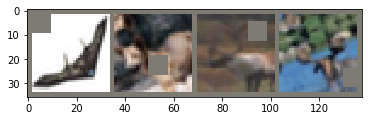

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
'''
def calculate_dataset_mean_std():
#     trainset = define
#     testset = define
    
    data = np.concatenate([trainset.data, testset.data], axis=0)
    data = data.astype(np.float32)/255.

    print("\nTotal dataset(train+test) shape: ", data.shape)

    means = []
    stdevs = []
    for i in range(3): # 3 channels
        pixels = data[:,:,:,i].ravel()
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))
        
    return means,stdevs
'''


def imshow(img):
    img[0] = img[0] * 0.2469 + 0.4918
    img[1] = img[1] * 0.2433 + 0.4826
    img[2] = img[2] * 0.2615 + 0.4471     # unnormalize = image * std + mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let us show some of the training images, for fun.



### 2. Model Summary





In [ ]:
# !pip3 install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = ResNet18().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
        BasicBlock-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
       BasicBlock-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## 3 . LR Finder

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


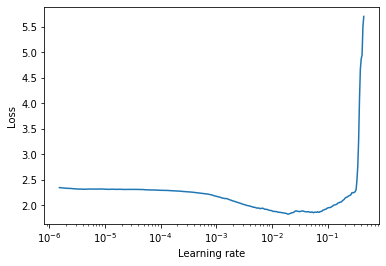

In [ ]:
import torch.optim as optim
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9 ) 

lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=None, start_lr=1e-6, end_lr=1,
                     num_iter= len(trainloader) , step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [ ]:
lr_finder.history.keys()

dict_keys(['lr', 'loss'])

In [ ]:
best_loss = lr_finder.best_loss
best_index = lr_finder.history['loss'].index(best_loss)
best_lr = lr_finder.history['lr'][best_index]

print(" Best loss value: {} \n Lowest loss at interation/index: {} \n Best starting lr: {}".
     format(best_loss,best_index,best_lr))

 Best loss value: 1.8261534812792157 
 Lowest loss at interation/index: 278 
 Best starting lr: 0.019800455987962512


## 4. Define a Loss function and optimizer -> Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
# samples_weight=[1.0,1.0,1.0,10.0,1.0,4.0,1.0,1.0,1.0,1.0]
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(samples_weight).to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= best_lr, momentum=0.9 ) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=False,threshold=0.1, min_lr=1e-4)
lr_list = []

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(net, device, trainloader, optimizer,criterion, epoch)
    training_loss = np.mean(np.array(train.train_losses))
    print("Mean Training_loss for a epoch: ",training_loss)
    scheduler.step(training_loss)    #LR scheduler based on training loss 
    test(net, device, testloader,criterion,epoch)
    for param_groups in optimizer.param_groups:
        print("\n  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \nAt epoch:{}, Learning rate ={} "
              .format(epoch+1,param_groups['lr']))  # print LR for different epochs
        lr_list.append(param_groups['lr'])
    
#     if(epoch<31):
#         scheduler = StepLR(optimizer, step_size=5, gamma=0.2)
#     else:
#         scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#     if(epoch % 10 == 0):
#         test(net, device, testloader,criterion,epoch)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.1620151996612549 Batch_id=390 Accuracy=41.75: 100%|██████████| 391/391 [00:16<00:00, 25.45it/s]

Mean Training_loss for a epoch:  1.5884404761711959



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 5431/10000 (54.31%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:1, Learning rate =0.019800455987962512 
EPOCH: 1


Loss=1.2447547912597656 Batch_id=390 Accuracy=56.28: 100%|██████████| 391/391 [00:16<00:00, 25.60it/s]

Mean Training_loss for a epoch:  1.4052014897394058



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6230/10000 (62.30%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:2, Learning rate =0.019800455987962512 
EPOCH: 2


Loss=0.8828369975090027 Batch_id=390 Accuracy=63.99: 100%|██████████| 391/391 [00:16<00:00, 25.87it/s]

Mean Training_loss for a epoch:  1.278881253844535



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 6552/10000 (65.52%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:3, Learning rate =0.019800455987962512 
EPOCH: 3


Loss=0.894365668296814 Batch_id=390 Accuracy=68.63: 100%|██████████| 391/391 [00:16<00:00, 25.31it/s] 


Mean Training_loss for a epoch:  1.184701969137277


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7258/10000 (72.58%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:4, Learning rate =0.019800455987962512 
EPOCH: 4


Loss=0.7899473905563354 Batch_id=390 Accuracy=72.06: 100%|██████████| 391/391 [00:16<00:00, 25.37it/s]

Mean Training_loss for a epoch:  1.1102563267930998



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7800/10000 (78.00%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:5, Learning rate =0.019800455987962512 
EPOCH: 5


Loss=0.5631783604621887 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:16<00:00, 25.51it/s]


Mean Training_loss for a epoch:  1.0495063269102767


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7902/10000 (79.02%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:6, Learning rate =0.019800455987962512 
EPOCH: 6


Loss=0.8292657732963562 Batch_id=390 Accuracy=76.14: 100%|██████████| 391/391 [00:16<00:00, 25.37it/s] 


Mean Training_loss for a epoch:  0.9985237537965227


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8201/10000 (82.01%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:7, Learning rate =0.019800455987962512 
EPOCH: 7


Loss=0.7975912094116211 Batch_id=390 Accuracy=77.62: 100%|██████████| 391/391 [00:16<00:00, 25.38it/s] 

Mean Training_loss for a epoch:  0.9548768221931841



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8342/10000 (83.42%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:8, Learning rate =0.019800455987962512 
EPOCH: 8


Loss=0.7256870269775391 Batch_id=390 Accuracy=78.77: 100%|██████████| 391/391 [00:16<00:00, 25.59it/s] 


Mean Training_loss for a epoch:  0.9173801381010737


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8184/10000 (81.84%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:9, Learning rate =0.019800455987962512 
EPOCH: 9


Loss=0.5261646509170532 Batch_id=390 Accuracy=79.81: 100%|██████████| 391/391 [00:16<00:00, 25.52it/s] 

Mean Training_loss for a epoch:  0.8841435816281896



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8424/10000 (84.24%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:10, Learning rate =0.019800455987962512 
EPOCH: 10


Loss=0.431693971157074 Batch_id=390 Accuracy=80.96: 100%|██████████| 391/391 [00:16<00:00, 25.42it/s]  

Mean Training_loss for a epoch:  0.8539548159906737



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8459/10000 (84.59%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:11, Learning rate =0.019800455987962512 
EPOCH: 11


Loss=0.31000077724456787 Batch_id=390 Accuracy=81.60: 100%|██████████| 391/391 [00:16<00:00, 25.49it/s]

Mean Training_loss for a epoch:  0.8272252388597043



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8619/10000 (86.19%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:12, Learning rate =0.019800455987962512 
EPOCH: 12


Loss=0.7295156717300415 Batch_id=390 Accuracy=82.69: 100%|██████████| 391/391 [00:16<00:00, 25.42it/s] 

Mean Training_loss for a epoch:  0.8023540158511474



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8369/10000 (83.69%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:13, Learning rate =0.019800455987962512 
EPOCH: 13


Loss=0.6178073883056641 Batch_id=390 Accuracy=83.03: 100%|██████████| 391/391 [00:16<00:00, 25.35it/s] 

Mean Training_loss for a epoch:  0.7801767040233261



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8546/10000 (85.46%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:14, Learning rate =0.019800455987962512 
EPOCH: 14


Loss=0.41346392035484314 Batch_id=390 Accuracy=83.99: 100%|██████████| 391/391 [00:16<00:00, 25.59it/s]

Mean Training_loss for a epoch:  0.7592402254020874



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8745/10000 (87.45%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:15, Learning rate =0.019800455987962512 
EPOCH: 15


Loss=0.604680061340332 Batch_id=390 Accuracy=84.74: 100%|██████████| 391/391 [00:16<00:00, 25.59it/s]  


Mean Training_loss for a epoch:  0.7395386826747176


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8623/10000 (86.23%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:16, Learning rate =0.019800455987962512 
EPOCH: 16


Loss=0.27985748648643494 Batch_id=390 Accuracy=85.32: 100%|██████████| 391/391 [00:16<00:00, 23.74it/s]

Mean Training_loss for a epoch:  0.7212178505586111



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8540/10000 (85.40%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:17, Learning rate =0.019800455987962512 
EPOCH: 17


Loss=0.5825625658035278 Batch_id=390 Accuracy=85.57: 100%|██████████| 391/391 [00:16<00:00, 25.74it/s] 

Mean Training_loss for a epoch:  0.7042864136827639



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8874/10000 (88.74%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:18, Learning rate =0.019800455987962512 
EPOCH: 18


Loss=0.38374564051628113 Batch_id=390 Accuracy=85.91: 100%|██████████| 391/391 [00:16<00:00, 25.52it/s]


Mean Training_loss for a epoch:  0.68848945770695


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8897/10000 (88.97%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:19, Learning rate =0.019800455987962512 
EPOCH: 19


Loss=0.35946792364120483 Batch_id=390 Accuracy=86.57: 100%|██████████| 391/391 [00:16<00:00, 25.55it/s]

Mean Training_loss for a epoch:  0.6736835687571322



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8779/10000 (87.79%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:20, Learning rate =0.019800455987962512 
EPOCH: 20


Loss=0.33323565125465393 Batch_id=390 Accuracy=87.14: 100%|██████████| 391/391 [00:16<00:00, 25.32it/s]

Mean Training_loss for a epoch:  0.6593434366561683



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8884/10000 (88.84%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:21, Learning rate =0.019800455987962512 
EPOCH: 21


Loss=0.36111190915107727 Batch_id=390 Accuracy=87.29: 100%|██████████| 391/391 [00:16<00:00, 25.68it/s]

Mean Training_loss for a epoch:  0.6461516148463788



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8948/10000 (89.48%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:22, Learning rate =0.019800455987962512 
EPOCH: 22


Loss=0.46574774384498596 Batch_id=390 Accuracy=87.76: 100%|██████████| 391/391 [00:16<00:00, 25.28it/s]

Mean Training_loss for a epoch:  0.6335647821270636



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8895/10000 (88.95%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:23, Learning rate =0.019800455987962512 
EPOCH: 23


Loss=0.4786052703857422 Batch_id=390 Accuracy=88.19: 100%|██████████| 391/391 [00:16<00:00, 25.77it/s] 

Mean Training_loss for a epoch:  0.6213551695265657



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8932/10000 (89.32%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:24, Learning rate =0.019800455987962512 
EPOCH: 24


Loss=0.36071792244911194 Batch_id=390 Accuracy=88.52: 100%|██████████| 391/391 [00:16<00:00, 25.62it/s]

Mean Training_loss for a epoch:  0.6098437100420218



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8974/10000 (89.74%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:25, Learning rate =0.019800455987962512 
EPOCH: 25


Loss=0.28758805990219116 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:16<00:00, 25.45it/s]

Mean Training_loss for a epoch:  0.5987865745261994



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9041/10000 (90.41%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:26, Learning rate =0.019800455987962512 
EPOCH: 26


Loss=0.36435210704803467 Batch_id=390 Accuracy=89.07: 100%|██████████| 391/391 [00:16<00:00, 25.23it/s]

Mean Training_loss for a epoch:  0.5883525867045823



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9061/10000 (90.61%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:27, Learning rate =0.009900227993981256 
EPOCH: 27


Loss=0.19524192810058594 Batch_id=390 Accuracy=90.84: 100%|██████████| 391/391 [00:16<00:00, 25.24it/s]

Mean Training_loss for a epoch:  0.5766209169778569



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9104/10000 (91.04%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:28, Learning rate =0.009900227993981256 
EPOCH: 28


Loss=0.24702081084251404 Batch_id=390 Accuracy=91.69: 100%|██████████| 391/391 [00:16<00:00, 25.40it/s]

Mean Training_loss for a epoch:  0.5649583116213168



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9118/10000 (91.18%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:29, Learning rate =0.009900227993981256 
EPOCH: 29


Loss=0.2738533616065979 Batch_id=390 Accuracy=91.95: 100%|██████████| 391/391 [00:16<00:00, 25.54it/s] 


Mean Training_loss for a epoch:  0.5539668888406223


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9138/10000 (91.38%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:30, Learning rate =0.009900227993981256 
EPOCH: 30


Loss=0.22458556294441223 Batch_id=390 Accuracy=92.04: 100%|██████████| 391/391 [00:16<00:00, 25.64it/s]

Mean Training_loss for a epoch:  0.5434141746523081



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9170/10000 (91.70%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:31, Learning rate =0.009900227993981256 
EPOCH: 31


Loss=0.18728230893611908 Batch_id=390 Accuracy=92.31: 100%|██████████| 391/391 [00:16<00:00, 25.53it/s]

Mean Training_loss for a epoch:  0.5333350347092999



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9177/10000 (91.77%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:32, Learning rate =0.009900227993981256 
EPOCH: 32


Loss=0.5041451454162598 Batch_id=390 Accuracy=92.32: 100%|██████████| 391/391 [00:16<00:00, 25.65it/s] 

Mean Training_loss for a epoch:  0.5238271371727719



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9214/10000 (92.14%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:33, Learning rate =0.004950113996990628 
EPOCH: 33


Loss=0.287034809589386 Batch_id=390 Accuracy=93.36: 100%|██████████| 391/391 [00:16<00:00, 25.52it/s]  


Mean Training_loss for a epoch:  0.5140804900073621


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9247/10000 (92.47%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:34, Learning rate =0.004950113996990628 
EPOCH: 34


Loss=0.10890035331249237 Batch_id=390 Accuracy=93.57: 100%|██████████| 391/391 [00:16<00:00, 25.35it/s]

Mean Training_loss for a epoch:  0.5046629398435104



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9277/10000 (92.77%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:35, Learning rate =0.004950113996990628 
EPOCH: 35


Loss=0.1309397965669632 Batch_id=390 Accuracy=93.62: 100%|██████████| 391/391 [00:16<00:00, 25.33it/s] 

Mean Training_loss for a epoch:  0.49564165627765416



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9280/10000 (92.80%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:36, Learning rate =0.004950113996990628 
EPOCH: 36


Loss=0.1897353231906891 Batch_id=390 Accuracy=93.99: 100%|██████████| 391/391 [00:16<00:00, 25.32it/s] 

Mean Training_loss for a epoch:  0.4869104722376856



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9245/10000 (92.45%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:37, Learning rate =0.004950113996990628 
EPOCH: 37


Loss=0.0666598379611969 Batch_id=390 Accuracy=94.05: 100%|██████████| 391/391 [00:16<00:00, 25.49it/s] 

Mean Training_loss for a epoch:  0.4785956093352722



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9298/10000 (92.98%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:38, Learning rate =0.004950113996990628 
EPOCH: 38


Loss=0.14493080973625183 Batch_id=390 Accuracy=94.12: 100%|██████████| 391/391 [00:16<00:00, 25.49it/s]


Mean Training_loss for a epoch:  0.4706449635662527


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9267/10000 (92.67%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:39, Learning rate =0.002475056998495314 
EPOCH: 39


Loss=0.16475407779216766 Batch_id=390 Accuracy=94.56: 100%|██████████| 391/391 [00:16<00:00, 25.56it/s] 

Mean Training_loss for a epoch:  0.4627252043655995



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9312/10000 (93.12%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:40, Learning rate =0.002475056998495314 
EPOCH: 40


Loss=0.15318706631660461 Batch_id=390 Accuracy=94.82: 100%|██████████| 391/391 [00:16<00:00, 25.48it/s]

Mean Training_loss for a epoch:  0.4551092741706417



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9302/10000 (93.02%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:41, Learning rate =0.002475056998495314 
EPOCH: 41


Loss=0.1670120805501938 Batch_id=390 Accuracy=94.92: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]  

Mean Training_loss for a epoch:  0.44772677707157266



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9322/10000 (93.22%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:42, Learning rate =0.002475056998495314 
EPOCH: 42


Loss=0.08455505222082138 Batch_id=390 Accuracy=94.90: 100%|██████████| 391/391 [00:16<00:00, 25.89it/s] 

Mean Training_loss for a epoch:  0.4406877038533429



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9309/10000 (93.09%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:43, Learning rate =0.002475056998495314 
EPOCH: 43


Loss=0.10510843992233276 Batch_id=390 Accuracy=94.91: 100%|██████████| 391/391 [00:16<00:00, 25.15it/s] 

Mean Training_loss for a epoch:  0.43397918484942205



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9317/10000 (93.17%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:44, Learning rate =0.002475056998495314 
EPOCH: 44


Loss=0.19483612477779388 Batch_id=390 Accuracy=94.95: 100%|██████████| 391/391 [00:16<00:00, 25.60it/s] 


Mean Training_loss for a epoch:  0.4275860528555588


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9323/10000 (93.23%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:45, Learning rate =0.002475056998495314 
EPOCH: 45


Loss=0.3161902129650116 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [00:16<00:00, 23.86it/s]  

Mean Training_loss for a epoch:  0.4213411118721294



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9309/10000 (93.09%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:46, Learning rate =0.001237528499247657 
EPOCH: 46


Loss=0.04599720239639282 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [00:16<00:00, 25.36it/s] 


Mean Training_loss for a epoch:  0.4153074842675529


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9335/10000 (93.35%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:47, Learning rate =0.001237528499247657 
EPOCH: 47


Loss=0.11014282703399658 Batch_id=390 Accuracy=95.40: 100%|██████████| 391/391 [00:16<00:00, 25.81it/s] 

Mean Training_loss for a epoch:  0.4094068077333329



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9315/10000 (93.15%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:48, Learning rate =0.001237528499247657 
EPOCH: 48


Loss=0.1541607826948166 Batch_id=390 Accuracy=95.53: 100%|██████████| 391/391 [00:16<00:00, 25.53it/s]  

Mean Training_loss for a epoch:  0.4036742802780312



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9331/10000 (93.31%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:49, Learning rate =0.001237528499247657 
EPOCH: 49


Loss=0.18307188153266907 Batch_id=390 Accuracy=95.37: 100%|██████████| 391/391 [00:16<00:00, 25.55it/s] 

Mean Training_loss for a epoch:  0.3982297283982682



Test set: Average loss: 0.0019, Accuracy: 9327/10000 (93.27%)


  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
At epoch:50, Learning rate =0.001237528499247657 


## 5. Test Accuracy Class-wise


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
#     net.eval()
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 89 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 85 %
Accuracy of  deer : 88 %
Accuracy of   dog : 87 %
Accuracy of  frog : 94 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 97 %


In [ ]:
## 6. GradCAM


In [ ]:
from gradcam_resnet18 import res18_gradcam , heatmap, grad_cam_draw

class gradcam_albumentations_Compose:
    def __init__(self):
        self.albumentations_transform = Compose([ToTensor()])
    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img
    
gradcam_albumentations_compose=gradcam_albumentations_Compose()
gradcam_set = torchvision.datasets.CIFAR10(root='./test_data', train=False,download=False, transform=gradcam_albumentations_compose)
batch_size = 128
dataloader = torch.utils.data.DataLoader(gradcam_set, batch_size=batch_size, shuffle=False, num_workers=12)


res18cam = res18_gradcam(net)


In [ ]:
from misclassfied import misclassified_images
# batch_size = 128

missclassified , predicted , correct = missclassified_images(testloader, net, classes, batch_size,device, number=25)

In [ ]:
def unnormalize(img):
    img[0] = img[0] * 0.2469 + 0.4918
    img[1] = img[1] * 0.2433 + 0.4826
    img[2] = img[2] * 0.2615 + 0.4471     # unnormalize = image * std + mean
#     npimg = img.numpy()
    return img

#### 6.1 GradCam on Random 25 misclassfied Images


True Label:- frog
model output:- plane
Prediction:- False


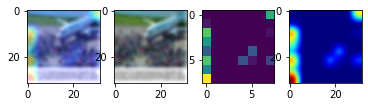



True Label:- bird
model output:- plane
Prediction:- False


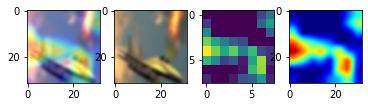



True Label:- cat
model output:- dog
Prediction:- False


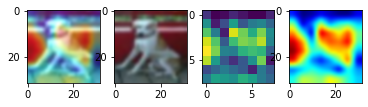



True Label:- truck
model output:- plane
Prediction:- False


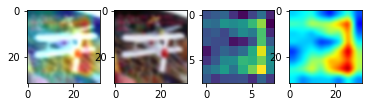



True Label:- plane
model output:- bird
Prediction:- False


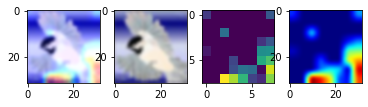



True Label:- truck
model output:- ship
Prediction:- False


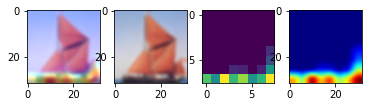



True Label:- dog
model output:- deer
Prediction:- False


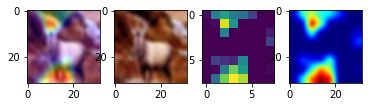



True Label:- deer
model output:- dog
Prediction:- False


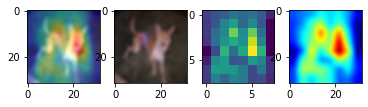



True Label:- plane
model output:- ship
Prediction:- False


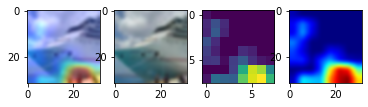



True Label:- cat
model output:- bird
Prediction:- False


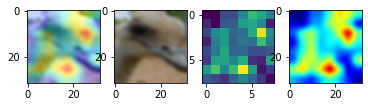



True Label:- bird
model output:- deer
Prediction:- False


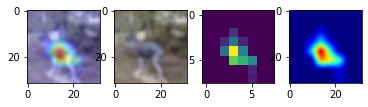



True Label:- deer
model output:- bird
Prediction:- False


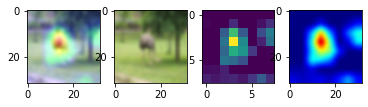



True Label:- deer
model output:- horse
Prediction:- False


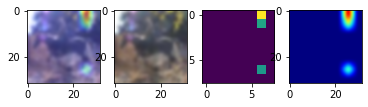



True Label:- horse
model output:- bird
Prediction:- False


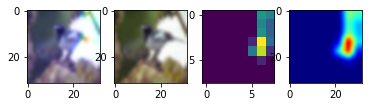



True Label:- dog
model output:- cat
Prediction:- False


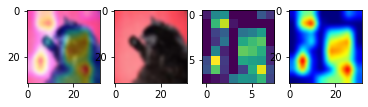



True Label:- truck
model output:- ship
Prediction:- False


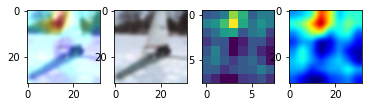



True Label:- car
model output:- truck
Prediction:- False


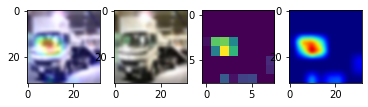



True Label:- dog
model output:- bird
Prediction:- False


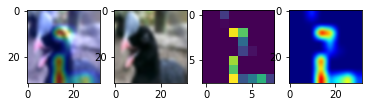



True Label:- plane
model output:- frog
Prediction:- False


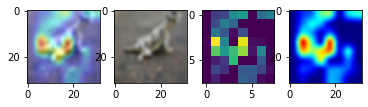



True Label:- dog
model output:- cat
Prediction:- False


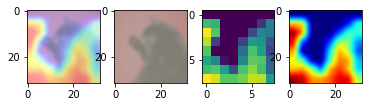



True Label:- frog
model output:- dog
Prediction:- False


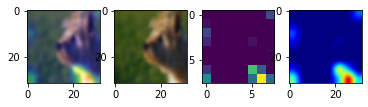



True Label:- cat
model output:- bird
Prediction:- False


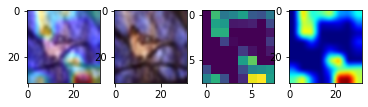



True Label:- ship
model output:- car
Prediction:- False


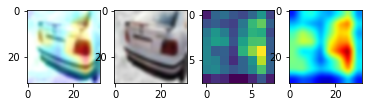



True Label:- plane
model output:- truck
Prediction:- False


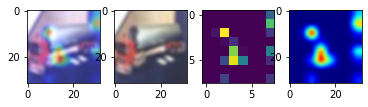



True Label:- horse
model output:- plane
Prediction:- False


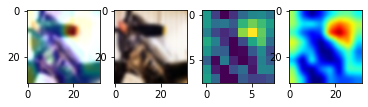

In [ ]:
rand_missclassided = np.random.randint(0,len(missclassified),size=25)
for index in rand_missclassided :
    image = unnormalize(missclassified[index][0])
    predicted_label = predicted[index]
    correct_label = correct[index]
    
    gradcam_heatmap,class_idx= heatmap(res18cam,net,image.unsqueeze(0),device,channels_number=256)
    
    print("True Label:-",classes[correct_label])
    print("model output:-",classes[predicted_label])
    print("Prediction:-",(predicted_label==correct_label))
    grad_cam_draw(image.unsqueeze(0).cpu(),gradcam_heatmap)
    print("\n")
    

## 7. Accuracy + LR Graph

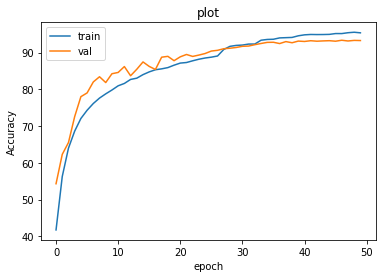

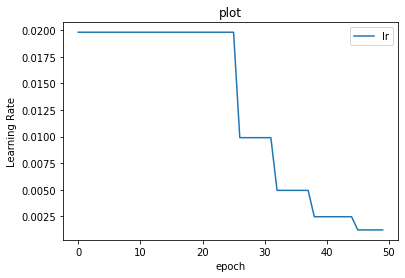

In [ ]:
from plot import plot_graph
plt_data1 = {
    "train": train.train_acc,
    "val": test.test_acc
}
plt_data2 = {
    "lr": lr_list
}
plot_graph(plt_data1, xlabel='epoch', ylabel='Accuracy' , title="plot")
plot_graph(plt_data2, xlabel='epoch', ylabel='Learning Rate' , title="plot")